## Sentiment Analysis of Twitter and Reddit Reviews

This project focuses on performing sentiment analysis on user-generated reviews from **Twitter** and **Reddit**. The goal is to classify each text as expressing **positive**, **negative**, or **neutral** sentiment.

We work with two datasets:

* **Training Data:** 162,980 samples with 2 columns (`text`, `label`)
* **Testing Data:** 37,249 samples with 2 columns (`text`, `label`)

The analysis includes:

* Preprocessing and cleaning of text data
* Feature extraction using NLP techniques (e.g., TF-IDF, tokenization)
* Model training using machine learning algorithms
* Evaluation and visualization of results

This project demonstrates how Natural Language Processing (NLP) can be used to extract sentiment insights from social media platforms.


### 1. Data Loading

Importing libraries and loading Twitter and Reddit datasets for sentiment analysis. Displaying the first few rows to inspect the structure.


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

df = pd.read_csv("Twitter_Data.csv")
df_reddit = pd.read_csv("Reddit_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### 2. Data Preprocessing & EDA

Cleaning the text data by removing noise (e.g., punctuation, stopwords) and performing exploratory data analysis to understand sentiment distribution and text characteristics.


In [3]:
print(df.shape)
print(df_reddit.shape)

(162980, 2)
(37249, 2)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [5]:
df.isna().sum()
df.dropna(inplace=True)

In [6]:
df_reddit.isna().sum()
df_reddit.dropna(inplace=True)

In [7]:
df["category"].value_counts()

category
 1.0    72249
 0.0    55211
-1.0    35509
Name: count, dtype: int64

<BarContainer object of 3 artists>

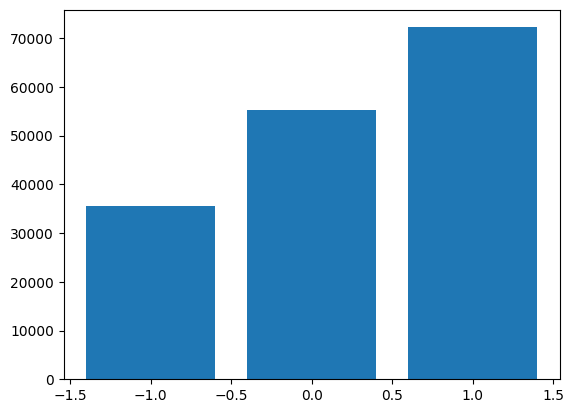

In [8]:
plt.bar(df["category"].value_counts().index , df["category"].value_counts().values)

<BarContainer object of 3 artists>

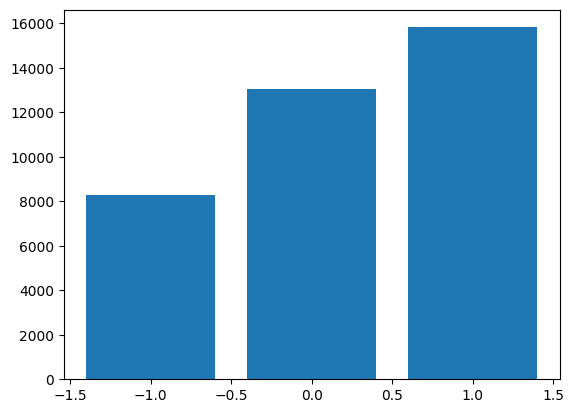

In [9]:
plt.bar(df_reddit["category"].value_counts().index , df_reddit["category"].value_counts().values)

In [10]:
# To concatenat Reddit and Twitter reviews
result = pd.concat([df, df_reddit], ignore_index=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
result["category"] = le.fit_transform(result["category"])

### 3. Text Cleaning & Normalization

Applying custom preprocessing to remove URLs, punctuation, repeated characters, emojis, and stopwords. Text is then lowercased and stemmed. Short or empty reviews are filtered out.


In [11]:
import emoji
import nltk
from nltk import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(stopwords.words('english'))
port_stemmer = PorterStemmer()

def preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'(.)\1{1,}', r'\1', text)
    text = emoji.demojize(text)
    text = text.split()
    text = [port_stemmer.stem(word) for word in text if not word in stopwords]
    text = " ".join(text)
    return text

result["preprocessed_reviews"] = result["clean_text"].apply(preprocessing)
                                                            # Keep rows where 'preprocced_text' has 2 or more words
result = result[result['preprocessed_reviews'].apply(lambda x: len(str(x).split()) >= 2)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nufal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nufal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [12]:
result.head()

,clean_text,category,clean_comment,preprocessed_reviews
0,when modi promised “minimum government maximum...,0,NaN,modi promis minimum govern maximum govern expe...
1,talk all the nonsense and continue all the dra...,1,NaN,talk al nonsens continu al drama wil vote modi
2,what did just say vote for modi welcome bjp t...,2,NaN,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,2,NaN,ask suport prefix chowkidar name modi great se...
4,answer who among these the most powerful world...,2,NaN,answer among power world leader today trump pu...


### 4. Sequence Length Analysis

Visualizing the distribution of review lengths (in words) to better understand the typical input size. This helps in setting sequence length limits for later tokenization or padding.


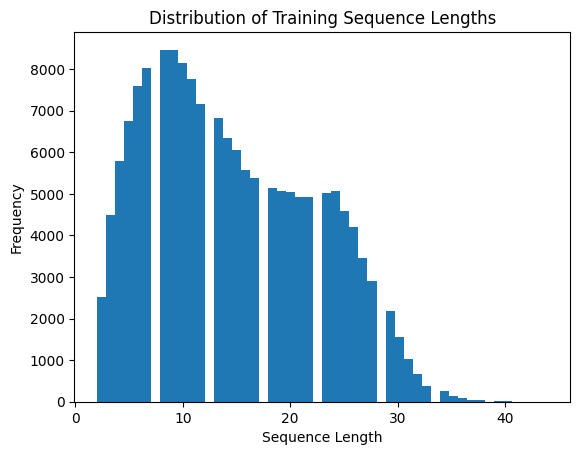

Max: 44
Mean: 14.55
90th percentile: 26.0


In [14]:
import matplotlib.pyplot as plt
lengthes = []
for i in result["preprocessed_reviews"]:
    lengthes.append(len(i.split()))

plt.hist(lengthes, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Training Sequence Lengths")
plt.show()

print(f"Max: {max(lengthes)}")
print(f"Mean: {sum(lengthes)/len(lengthes):.2f}")
print(f"90th percentile: {np.percentile(lengthes, 90)}")

### 5. Feature and Label Separation + Data Splitting

Separating the cleaned text and sentiment labels, then splitting the data into training and testing sets using stratified sampling to maintain class balance.


In [38]:
X = result["preprocessed_reviews"].values
Y = result["category"].values

In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test  = train_test_split(X,Y,test_size=0.2 , stratify=Y, random_state=42)

### 6. TF-IDF Vectorization & Top Word Analysis

Converting text data into numerical features using TF-IDF. Then, identifying and visualizing the top 10 words with the highest overall importance across the training set.


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)


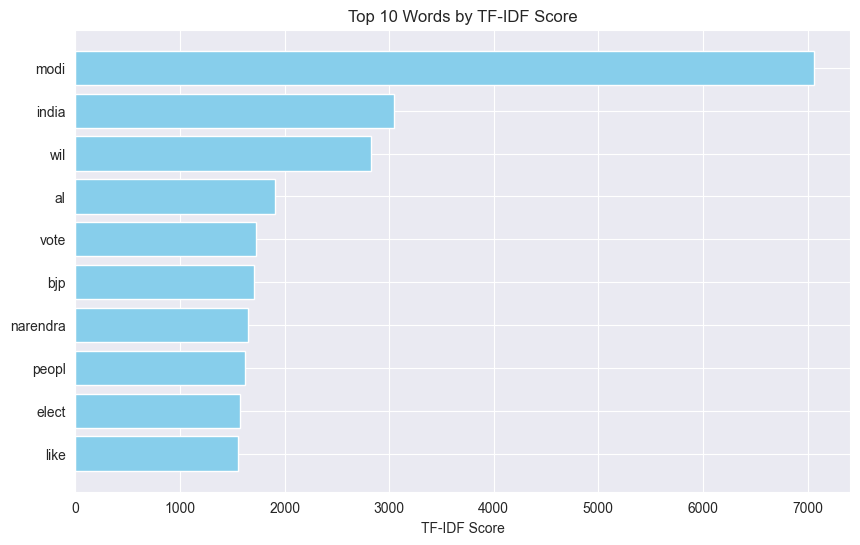

In [42]:
# 2. Sum the TF-IDF values for each word (across all documents)
tfidf_scores = x_train.sum(axis=0)  # shape is (1, num_words)
scores = tfidf_scores.A1  # Convert to 1D array

# 3. Map scores to words
words = vectorizer.get_feature_names_out()
word_scores = dict(zip(words, scores))

# 4. Sort words by their TF-IDF scores
sorted_words = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

# 5. Plot top N words
top_n = 10
top_words = sorted_words[:top_n]

words, scores = zip(*top_words)
plt.figure(figsize=(10, 6))
plt.barh(words, scores, color='skyblue')
plt.xlabel("TF-IDF Score")
plt.title(f"Top {top_n} Words by TF-IDF Score")
plt.gca().invert_yaxis()
plt.show()

### 7. Model Training and Evaluation

Applying various machine learning models (e.g., Logistic Regression, SVM, Random Forest) to classify sentiment. Each model is trained on the TF-IDF features and evaluated using standard metrics.


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=10000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.72      0.77      7098
           1       0.82      0.91      0.86     10907
           2       0.87      0.86      0.87     14429

    accuracy                           0.84     32434
   macro avg       0.84      0.83      0.83     32434
weighted avg       0.84      0.84      0.84     32434



In [44]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.74      0.78      7098
           1       0.83      0.90      0.86     10907
           2       0.88      0.86      0.87     14429

    accuracy                           0.85     32434
   macro avg       0.84      0.83      0.84     32434
weighted avg       0.85      0.85      0.85     32434



In [49]:
from xgboost import XGBClassifier
XGB = XGBClassifier(eval_metric='logloss', random_state=42)
XGB.fit(x_train, y_train)
y_pred = XGB.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.61      0.71      7098
           1       0.73      0.94      0.82     10907
           2       0.87      0.80      0.84     14429

    accuracy                           0.81     32434
   macro avg       0.81      0.78      0.79     32434
weighted avg       0.82      0.81      0.80     32434



In [52]:
def predict_using_model(text, model):
    new_text_tfidf = vectorizer.transform([text])
    prediction = model.predict(new_text_tfidf)
    print(f"Predicted class: {prediction[0]}")
    if prediction[0] == 0:
        print("Negative")
    elif prediction[0] == 1:
        print("Neutral")
    else:
        print("Positive")

In [54]:
print("Linear Regression: ")
predict_using_model("I Hate you",lr)
print("-"*100)
print("SVM: ")
predict_using_model("I Hate you",svm_model)
print("-"*100)
print("XGBoost: ")
predict_using_model("I Hate you",XGB)

Linear Regression: 
Predicted class: 0
Negative
----------------------------------------------------------------------------------------------------
SVM: 
Predicted class: 0
Negative
----------------------------------------------------------------------------------------------------
XGBoost: 
Predicted class: 0
Negative
